In [34]:
import pandas as pd
import kaggle as kg
import os
import cv2
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.applications import VGG16
from keras.optimizers import SGD
from keras.layers import Conv2D
from xml.etree import ElementTree as ET

In [31]:
def anchor_boxes(image_size,grids_size,aspect_ratios):

    image_width, image_height, _ = image_size

    grid_width = image_width//grids_size[0]
    grid_height = image_height//grids_size[1]

    grid_center_x_start = grid_width//2
    grid_center_x_end = (grids_size[0] - 0.5)*grid_width 

    grid_center_x = np.linspace(grid_center_x_start,grid_center_x_end,grids_size[0])

    grid_center_y_start = grid_height//2
    grid_center_y_end = (grids_size[1] - 0.5)*grid_height

    grid_center_y = np.linspace(grid_center_y_start,grid_center_y_end,grids_size[1])

    grid_center_x_mesh, grid_center_y_mesh = np.meshgrid(grid_center_x,grid_center_y)

    grid_center_x_mesh = np.expand_dims(grid_center_x_mesh,-1)
    grid_center_y_mesh = np.expand_dims(grid_center_y_mesh,-1)

    anchor_boxes_no = len(aspect_ratios)

    anchor_boxes_tensor = np.zeros((grids_size[0],grids_size[1],anchor_boxes_no,4))

    anchor_boxes_tensor[...,0] = np.tile(grid_center_x_mesh,(1,1,anchor_boxes_no))
    anchor_boxes_tensor[...,1] = np.tile(grid_center_y_mesh,(1,1,anchor_boxes_no))

    anchor_box_width_height = list()

    for aspect_ratio in aspect_ratios:

        anchor_box_width_height.append((grid_width*np.sqrt(aspect_ratio),
                                        grid_height/np.sqrt(aspect_ratio)))
        
    anchor_box_width_height = np.array(anchor_box_width_height)

    anchor_boxes_tensor[...,2] = anchor_box_width_height[:,0]
    anchor_boxes_tensor[...,3] = anchor_box_width_height[:,1]

    return anchor_boxes_tensor

In [4]:
def centroid2minmax(anchor_boxes_centroid_tensor):

    anchor_boxes_minmax_tensor = np.copy(anchor_boxes_centroid_tensor)

    anchor_boxes_minmax_tensor[...,0] = anchor_boxes_minmax_tensor[...,0] - (anchor_boxes_minmax_tensor[...,2]//2)
    anchor_boxes_minmax_tensor[...,1] = anchor_boxes_minmax_tensor[...,1] - (anchor_boxes_minmax_tensor[...,3]//2)
    anchor_boxes_minmax_tensor[...,2] = anchor_boxes_minmax_tensor[...,0] + (anchor_boxes_minmax_tensor[...,2]//2)
    anchor_boxes_minmax_tensor[...,3] = anchor_boxes_minmax_tensor[...,1] + (anchor_boxes_minmax_tensor[...,3]//2)

    return anchor_boxes_minmax_tensor

In [5]:
def compute_IoU(anchor_boxes_tensor,image_gt_bbox_coords):

    IoU_tensor = np.zeros(len(image_gt_bbox_coords),anchor_boxes_tensor.shape[0],anchor_boxes_tensor.shape[1],anchor_boxes_tensor.shape[2])
    anchor_boxes_minmax_tensor = centroid2minmax(anchor_boxes_tensor)

    gt_bboxes_mask = np.zeros(len(image_gt_bbox_coords),anchor_boxes_tensor.shape[0],anchor_boxes_tensor.shape[1],anchor_boxes_tensor.shape[2])

    for i in range(len(image_gt_bbox_coords)):

        centroid_x_condition = (anchor_boxes_minmax_tensor[:,:,0,0]<(image_gt_bbox_coords[i,0]+image_gt_bbox_coords[i,2]//2)) & (anchor_boxes_minmax_tensor[:,:,0,2]>(image_gt_bbox_coords[i,0]+image_gt_bbox_coords[i,2]//2))
        centroid_y_condition = (anchor_boxes_minmax_tensor[:,:,0,1]<(image_gt_bbox_coords[i,1]+image_gt_bbox_coords[i,3]//2)) & (anchor_boxes_minmax_tensor[:,:,0,3]>(image_gt_bbox_coords[i,1]+image_gt_bbox_coords[i,3]//2))

        idxes = np.argwhere((centroid_x_condition & centroid_y_condition))

        gt_bboxes_mask[i,idxes,:] = 1.0

        for j in range(anchor_boxes_tensor.shape[2]):

            xmin_intersection = np.max(image_gt_bbox_coords[i][0],anchor_boxes_minmax_tensor[:,:,j,0])
            ymin_intersection = np.max(image_gt_bbox_coords[i][1],anchor_boxes_minmax_tensor[:,:,j,1])

            xmax_intersection = np.min(image_gt_bbox_coords[i][0]+image_gt_bbox_coords[i][2],anchor_boxes_minmax_tensor[:,:,j,2])
            ymax_intersection = np.min(image_gt_bbox_coords[i][1]+image_gt_bbox_coords[i][3],anchor_boxes_minmax_tensor[:,:,j,3])

            intersection_width = np.max(0,(xmax_intersection - xmin_intersection))
            intersection_height = np.max(0,(ymax_intersection - ymin_intersection))

            intersection_area = intersection_width * intersection_height

            image_gt_bbox_area = image_gt_bbox_coords[i][2] * image_gt_bbox_coords[i][3]
            anchor_boxes_width = (anchor_boxes_minmax_tensor[:,:,j,2] - anchor_boxes_minmax_tensor[:,:,j,0])
            anchor_boxes_height = (anchor_boxes_minmax_tensor[:,:,j,3] - anchor_boxes_minmax_tensor[:,:,j,1])

            union_area = ((anchor_boxes_width * anchor_boxes_height) + image_gt_bbox_area) - intersection_area

            IoU_tensor[i,:,:,j] = intersection_area/union_area
    
    confidence_score = IoU_tensor * gt_bboxes_mask

    return gt_bboxes_mask, IoU_tensor, confidence_score

In [6]:
def normalize_bbox_coords(image_size, image_gt_bbox_coords, gt_bboxes_mask, anchor_boxes_tensor):

    image_width, image_height, _ = image_size
    normalized_image_gt_bbox_coords = np.zeros_like(anchor_boxes_tensor)
    
    for i in range(len(image_gt_bbox_coords)):

        idx = np.argwhere(gt_bboxes_mask[i,:,:,0] == 1.0)
        normalized_image_gt_bbox_coords[idx,:,0] = (image_gt_bbox_coords[i][0] + (image_gt_bbox_coords[i][2]//2))/(image_gt_bbox_coords[i][0] + image_gt_bbox_coords[i][2])
        normalized_image_gt_bbox_coords[idx,:,1] = (image_gt_bbox_coords[i][1] + (image_gt_bbox_coords[i][3]//2))/(image_gt_bbox_coords[i][1] + image_gt_bbox_coords[i][3])
        normalized_image_gt_bbox_coords[idx,:,2] = image_gt_bbox_coords[i][2]//image_width
        normalized_image_gt_bbox_coords[idx,:,3] = image_gt_bbox_coords[i][3]//image_height

    return normalized_image_gt_bbox_coords

In [7]:
def create_gt_labels_tensor(normalized_image_gt_bbox_coords, IoU_tensor, gt_bboxes_mask, image_cls_labels):

    cls_probabilities_tensor = np.zeros((normalized_image_gt_bbox_coords.shape[0],normalized_image_gt_bbox_coords.shape[1],80))

    for i in range(gt_bboxes_mask.shape[0]):

        idx = np.argwhere(gt_bboxes_mask[i,:,:,0] == 1.0)
        cls_probabilities_tensor[idx,:] = np.eye(80,80)[image_cls_labels[i]]

    gt_labels_tensor = np.copy(normalized_image_gt_bbox_coords)
    modified_iou_tensor = IoU_tensor[0,:,:,:]
    modified_iou_tensor = np.expand_dims(modified_iou_tensor,-1)
    gt_labels_tensor = np.concatenate((gt_labels_tensor,modified_iou_tensor),axis=3)
    gt_labels_tensor = gt_labels_tensor.reshape(gt_labels_tensor.shape[0],gt_labels_tensor.shape[1],gt_labels_tensor.shape[2]*gt_labels_tensor.shape [3])

    gt_labels_tensor = np.concatenate((gt_labels_tensor,cls_probabilities_tensor),axis=2)
    
    return gt_labels_tensor  #(7,7,90)

In [10]:
def multiclass_cnn():

    vgg16 = VGG16(include_top=False,input_shape=(640,480,3),weights="imagenet",pooling=None)
    vgg16.trainable = False
    input_to_vgg16 = vgg16.input
    vgg16_output = Conv2D(filters=90,kernel_size=(14,9))(vgg16.layers[-1].output)

    return Model(inputs=[input_to_vgg16],outputs=[vgg16_output])

In [11]:
model = multiclass_cnn()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 640, 480, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 640, 480, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 640, 480, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 320, 240, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 320, 240, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 320, 240, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 160, 120, 128)     0   

In [12]:
def train_test_df(imgs_base_path,annotations_base_path):

    img_complete_paths = list()
    img_class_labels = list()
    img_gt_bbox_coords = list()

    for single_img_complete_path in pathlib.Path(imgs_base_path).glob("*"):

        img_path = str(single_img_complete_path)
        img_label_path = os.path.join(annotations_base_path,str(single_img_complete_path).split("/")[-1].split(".")[0]+".xml")

        class_gt_labels_list = list()
        gt_bbox_coords_list = list()

        tree = ET.parse(img_label_path)
        root = tree.getroot()

        for member in root.findall("object"):
            """
            for child in member:

                if child.tag == "name":
                    class_gt_labels_list.append(child.text)

                if child.tag == "bndbox":
                    xmin = float(child[0].text)
                    ymin = float(child[1].text)
                    xmax = float(child[2].text)
                    ymax = float(child[3].text)
            """
            class_gt_labels_list.append(member.find("name").text)
            xmin = float(member.find("bndbox/xmin").text)
            ymin = float(member.find("bndbox/ymin").text)
            xmax = float(member.find("bndbox/xmax").text)
            ymax = float(member.find("bndbox/ymax").text)
            
            bbox_width = xmax - xmin
            bbox_height = ymax - ymin
            

            gt_bbox_coords_list.append([xmin,ymin,bbox_width,bbox_height])

        img_complete_paths.append(str(single_img_complete_path))
        img_class_labels.append(class_gt_labels_list)
        img_gt_bbox_coords.append(gt_bbox_coords_list)

    return pd.DataFrame(data={"img_path":img_complete_paths,
                              "img_gt_class_labels":img_class_labels,
                              "img_gt_bbox_coords":img_gt_bbox_coords})

In [13]:
data_df = train_test_df("/home/thasin/class-projects/annotate/dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages","/home/thasin/class-projects/annotate/dataset/VOC2012_train_val/VOC2012_train_val/Annotations")

In [15]:
data_df.shape

(17125, 3)

In [16]:
training_data = data_df.iloc[0:15000,:]
cv_data = data_df.iloc[15000:,]

In [17]:
training_data.shape

(15000, 3)

In [18]:
cv_data.shape

(2125, 3)

In [20]:
training_data.head(10)

,img_path,img_gt_class_labels,img_gt_bbox_coords
0,/home/thasin/class-projects/annotate/dataset/V...,"[person, person, sheep]","[[456.0, 3.0, 44.0, 372.0], [175.0, 81.0, 151...."
1,/home/thasin/class-projects/annotate/dataset/V...,[person],"[[114.0, 46.0, 205.0, 239.0]]"
2,/home/thasin/class-projects/annotate/dataset/V...,"[person, chair, person, person, chair, diningt...","[[271.0, 126.0, 189.0, 174.0], [432.0, 206.0, ..."
3,/home/thasin/class-projects/annotate/dataset/V...,"[sofa, tvmonitor, person, person]","[[1.0, 221.0, 336.0, 155.0], [188.0, 171.0, 56..."
4,/home/thasin/class-projects/annotate/dataset/V...,"[motorbike, motorbike, person, person, person,...","[[34.0, 114.0, 256.0, 212.0], [208.0, 126.0, 1..."
5,/home/thasin/class-projects/annotate/dataset/V...,"[pottedplant, pottedplant, train, person, pers...","[[270.0, 137.0, 24.0, 26.0], [365.0, 139.0, 48..."
6,/home/thasin/class-projects/annotate/dataset/V...,[dog],"[[145.0, 74.0, 221.0, 210.0]]"
7,/home/thasin/class-projects/annotate/dataset/V...,"[tvmonitor, bottle, person, chair, sofa]","[[8.0, 52.0, 128.0, 109.0], [454.0, 23.0, 9.0,..."
8,/home/thasin/class-projects/annotate/dataset/V...,[train],"[[144.0, 177.0, 256.0, 118.0]]"
9,/home/thasin/class-projects/annotate/dataset/V...,[dog],"[[210.0, 1.0, 290.0, 353.0]]"


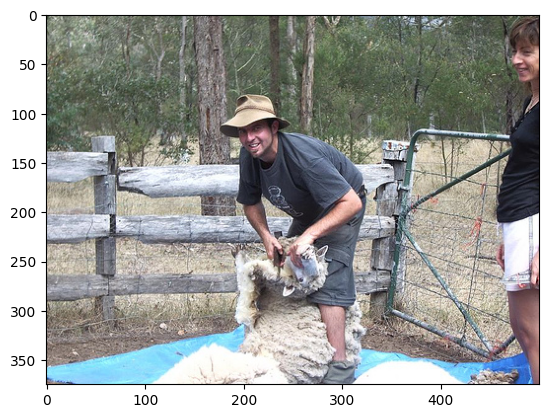

In [26]:
plt.imshow(plt.imread(training_data.iloc[0,0])) # row,column

In [27]:
training_data.iloc[0,1]

['person', 'person', 'sheep']

In [28]:
training_data.iloc[0,2]

[[456.0, 3.0, 44.0, 372.0],
 [175.0, 81.0, 151.0, 294.0],
 [191.0, 226.0, 131.0, 149.0]]

In [32]:
anchor_boxes_tensor = anchor_boxes((640,480,3),(7,7),(1/2,2)) #ask tommorow

In [33]:
def custom_data_generator(df,mb_size):

    for i in range(df.shape[0]//mb_size):

        X_train_mb = list()
        Y_train_mb = list()

        for j in range(0,mb_size):

            df_mb = df.iloc[(i*mb_size)+j]
            img_path = df_mb["img_path"]

            X_train_mb.append(cv2.resize(plt.imread(img_path),(480,640))) # error

            gt_bboxes_mask, iou_tensor = compute_IoU(anchor_boxes_tensor,df_mb["img_gt_bbox_coords"])
            normalized_img_gt_bbox_coords = normalize_bbox_coords((640,480,3),df_mb["img_gt_bbox_coords"],
                                                                  gt_bboxes_mask,anchor_boxes_tensor)
            Y_train_mb.append(create_gt_labels_tensor(normalized_img_gt_bbox_coords,iou_tensor,gt_bboxes_mask,
                                                      df_mb["img_gt_class_labels"],20))
            
        yield X_train_mb, Y_train_mb

In [35]:
def loss_fn(y_train_mb, y_pred_mb):

    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true=y_train_mb,
                                                                          y_pred=y_pred_mb))
optimizer = SGD()

In [37]:
training_data_generator = custom_data_generator(training_data,5)


In [42]:
model1 = model.compile(optimizer=SGD(),loss="mean_squared_error")

In [ ]:
print("")

In [ ]:
epochs = 50
learning_rate = 0.001
mb_size = 5

def train_model():
   for epoch in range(epochs):
       
       training_data_generator = custom_data_generator(training_data,mb_size)
    
    

In [ ]:
import numpy as np

# Example training function
def train_model(model, data_generator, epochs, steps_per_epoch, optimizer, loss_fn):
    # Compile the model with the given optimizer and loss function
    model.compile(optimizer=optimizer, loss=loss_fn)

    # Loop over epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Reset metrics at the start of each epoch
        epoch_loss = 0

        # Loop over batches within an epoch
        for step in range(steps_per_epoch):
            # Get the next batch from the data generator
            X_train_mb, Y_train_mb = next(data_generator)

            # Train the model on the current batch
            batch_loss = model.train_on_batch(X_train_mb, Y_train_mb)

            # Accumulate the loss for the current epoch
            epoch_loss += batch_loss

            if step % 10 == 0:
                # Print progress for every 10 steps
                print(f"Step {step}/{steps_per_epoch} - Batch Loss: {batch_loss:.4f}")

        # Calculate and print the average loss for the epoch
        avg_epoch_loss = epoch_loss / steps_per_epoch
        print(f"Epoch {epoch + 1} - Average Loss: {avg_epoch_loss:.4f}")

# Example usage
# Assuming you have a defined model, data generator, optimizer, and loss function
epochs = 10
steps_per_epoch = 100  # Number of batches per epoch
optimizer = 'adam'  # You can also use Adam, SGD, etc.
loss_fn = 'mean_squared_error'  # Replace with the appropriate loss function for YOLO

train_model(model, data_generator, epochs, steps_per_epoch, optimizer, loss_fn)
